# News Articles Recommendation

## 1. Collect Active Twitter Users' Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#to scrape Twitter
import tweepy
from tweepy import OAuthHandler
 
#warning    
import warnings
warnings.filterwarnings('ignore')

In [13]:
#authorizing twitter api with consumer key and secrets
consumer_key = 'WwzFApr0hzEcMlHqAsxN0qxrK'
consumer_secret = 'TU756bVsmWa9YtIEsKwdCAqnfeqKCo63KvHvQANoPXuPf3CVF4'
access_token = '1354374554-DTnvbTCT9gBqG17ZiLveimyOlhTfiYajJRCvgL8'
access_secret = 'QGnnrOnImC7c7ywQUKQhv9kNyKc31kecy3GaZdTNIMkEm'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

We can get users who actively retweet news articles from popular news channels' twitter handles

In [14]:
def get_users(twitterNewsChannels,NumberofTweet):
    """This function fetch users who retweet given News handle's tweets 
    
    Input: 
      TwitterNewsChannels - List of news channels' twitter handles
      NumberofTweet = int number of tweet to analyze on this twitter handle
    Return:
      DataFrame of Users ActiveNewsReaders, Popularity, Verified, TotalTweets
      """
    usersFromTweets = pd.DataFrame(columns = ["ActiveNewsReaders","Popularity", "Verified","totalTweets"])
    numberOfUsersMined = 0
    
    for newsChannel in twitterNewsChannels:
        for tweet in api.user_timeline(screen_name = newsChannel, count=NumberofTweet):
            for reTweet in api.retweets(tweet.id):
                
                usersFromTweets.loc[numberOfUsersMined, "ActiveNewsReaders"] = reTweet.user.screen_name
                
                if(reTweet.user.friends_count == 0):
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count
                else:
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count/reTweet.user.friends_count
                
                usersFromTweets.loc[numberOfUsersMined, "Verified"] = reTweet.user.verified
                usersFromTweets.loc[numberOfUsersMined, "totalTweets"] = reTweet.user.statuses_count
                
                numberOfUsersMined+=  1
                
                if numberOfUsersMined %100 ==0:
        
                  time.sleep(6)
    return usersFromTweets

To fetch users, let's provide 3 news providers' twitter handles.
- New York Times - @nytimes
- CNN News - @CNN
- Washington Post - @washingtonpost

We will fetch the users who retweeted 50 top tweets of these news providers.

In [15]:
NewsChannelsUsernames = ["nytimes","CNN","washingtonpost"]
usersData = get_users(NewsChannelsUsernames, 25)

Let's see our active news readers

In [16]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets
0,SaraGomezAranci,4.2959,False,699171
1,Lizi_he_taozi,0.105125,False,5327
2,TopFeaturedcom,0.933525,False,974
3,Mubarak17625482,0.285425,False,20240
4,Fred19939,0.05,False,13


In [17]:
# users might retweetted muliple tweets so, we removed the duplicate users
usersData.drop_duplicates(inplace = True)
usersData.shape

(948, 4)

To make sure that all users are authentic let's filter them based on their popularity and their twitter activity.

In [23]:
# Filetered users with tweets > 10 and popularity 
usersData = usersData[(usersData.totalTweets > 10) & (usersData.Popularity > 1)]
usersData.shape

(301, 4)

In [24]:
usersData = usersData.reset_index(drop=True)

Now we have list of active users from which we can get their information. Following function will extract each user's top 20 tweets

In [25]:
def getTweets(user):
    # Get Ten Tweets from the each user
    twitterUser = api.get_user(user)
    
    tweets = api.user_timeline(screen_name = user, count = 10,tweet_mode='extended')
    tentweets = []
    for tweet in tweets:
        if tweet.full_text.startswith("RT @") == True:
            tentweets.append(tweet.retweeted_status.full_text)
        else:
            tentweets.append(tweet.full_text)
       
    return tentweets

In [26]:
vfunc = np.vectorize(getTweets)
usersData["tweets"] = usersData['ActiveNewsReaders'].apply(lambda x: getTweets(x))

In [27]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,SaraGomezAranci,4.2959,False,699171,[2016/17: Brighton ✅\n2017/18: Fulham ✅\n2018/...
1,Follow14301384,1.18314,False,3828,[Exclusive: Footage obtained by Sky News track...
2,TitaniumJanes,1.02724,False,87414,[I don't think the economy is great. \n\nGroce...
3,BillEsteem,1.0029,False,11173,[Guantanamo Bay commander fired over 'loss of ...
4,JoseGarcia0154,1.96629,False,5919,"[@NachoRgz @QuesaVerdades Es muy fácil hablar,..."
5,clar_idadE,1.19273,False,105001,[Atrocidades contra los nicaragüenses podrían ...
6,kayblahc,2.19118,False,27667,[Opinion: Lindsey Graham’s shamelessness https...
7,LngbrdinDave,1.00364,False,198947,[Nobody: \n\nDr. Strange: https://t.co/W3FI88p...
8,frogmarge,1.55172,False,4955,[@McFaul An economy that has been growing for ...
9,carnedecapital,1.09208,False,377566,"[ÚLTIMA HORA | Boye, Trias y Talegón sustituye..."


Since, the tweets are not clean we will have to preprocess them.

## 2. Analyze Users' Tweets

In [62]:
#to preprocess tweets
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\archd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\archd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\archd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
def processTweets(tweets):
    
    #cleaning of tweets
    cleanedTweets = []
    for tweet in tweets:
        tw = re.sub('http\S+', '', tweet) #remove links
        tw = re.sub('RT', '', tw) #remove RT of retweet
        tw = re.sub('@[^\s]+','',tw) #remove usernames 
        tw = "".join([char for char in tw if char not in string.punctuation]) #remove punctuations
        tw = tw.lower() #converting to lowercase letters
        tw = ' '.join([word for word in tw.split() if word not in (stop)]) #removing stop words
        tw = ' '.join([word for word in tw.split() if len(word)>2])
        cleanedTweets.append(tw)

    cleanedTweets = ' '.join(cleanedTweets) #joining all tweets
    
    #tokenization
    ProcessedTweets = word_tokenize(cleanedTweets)
    
    #stemming
    ProcessedTweets = [ps.stem(word) for word in ProcessedTweets]
    
    #lammitization
    ProcessedTweets = [wn.lemmatize(word) for word in ProcessedTweets]
    
    ProcessedTweets = [word for word in ProcessedTweets if len(word)>2]
    
    ProcessedTweets = ' '.join(w for w in ProcessedTweets if w in words)
    
    return ProcessedTweets
        

In [88]:
usersData["ptweets"] = usersData['tweets'].apply(lambda x : processTweets(x))

In [89]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets
0,Follow14301384,1.18314,False,3828,[Exclusive: Footage obtained by Sky News track...,obtain sky news track final hour one sri bombe...
1,TitaniumJanes,1.02724,False,87414,[I don't think the economy is great. \n\nGroce...,dont think great higher higher minimum wage ta...
2,BillEsteem,1.0029,False,11173,[Guantanamo Bay commander fired over 'loss of ...,bay command fire loss renew sector project coa...
3,JoseGarcia0154,1.96629,False,5919,"[@NachoRgz @QuesaVerdades Es muy fácil hablar,...",son prejudicial tweet bien verbal junto best i...
4,clar_idadE,1.19273,False,105001,[Atrocidades contra los nicaragüenses podrían ...,contra important pan minimum wage would today ...


## 3. Cluster users according to their interests

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os

import matplotlib.pyplot as plt

To cluster users based on their twitter contents we need to convert tweets into vectorized form

In [91]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(usersData.ptweets)

In [92]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.18988029,
        0.        ],
       [0.24203926, 0.        , 0.        , ..., 0.        , 0.        ,
        0.15474844],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22336402, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.18567457,
        0.        ]])

Let's see the Tf-Idf matrix with readers and words

In [99]:
tfidf_matrix.shape

(300, 112)

In [100]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = usersData.ActiveNewsReaders)

,also,appear,ask,attack,back,big,break,call,care,case,...,watch,way,week,well,white,woman,work,world,would,year
ActiveNewsReaders,,,,,,,,,,,,,,,,,,,,,
Follow14301384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.316752,0.000000,0.177058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TitaniumJanes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.224476,0.000000,0.000000,0.000000,0.207953,0.210710,0.000000,0.189880,0.000000
BillEsteem,0.242039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.201597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154748
JoseGarcia0154,0.000000,0.000000,0.000000,0.000000,0.205354,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.389502,0.000000,0.000000,0.000000,0.000000,0.000000
clar_idadE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240768,0.000000,...,0.198594,0.000000,0.000000,0.000000,0.000000,0.389374,0.000000,0.222019,0.355534,0.000000
kayblahc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221248,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215677,0.000000,0.000000
LngbrdinDave,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
frogmarge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.183036,0.000000,0.000000,0.000000,0.339127,0.000000,0.000000,0.000000,0.265542
carnedecapital,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Using this generated Tf-Idf matrix we can cluster the users.

In [111]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [112]:
km.cluster_centers_.argsort()[:, ::-1]

array([[ 42,  14,  36,  59, 110,  29,  11,  74,  32,  26,  91, 107,  75,
         34,  28,  78,  54,  56,  44,  17,  27,  58,  47,  92,  45, 106,
         84, 101,  33, 111,  82,  86,  35,  63,  97, 109, 108,  43,   8,
         39,  72,  41,  80, 104,  90,   9,  22,  71,  37,  21,  81,   4,
         15,  93,  51,  10,  62,  94,  50,  49,  13,  48,  18,  65, 102,
         55,  83,  25,  46,  85,  87, 105,   6,  73,  61,  95, 100,  57,
         98,  30,  53,  70, 103,  64,  66,  24,  60,  12,  69,  89,  20,
          3,   2,  96,  40,  38,  19,   7,  68,  77,  88,  67,  76,   5,
         16,  99,   0,  31,  52,  23,  79,   1],
       [ 79,  83,  41,  16,  74,  96,  73,  59,  56,  98,  52,  50, 111,
        104, 105,  92,  48,  87,  45,  57,  94,  22,  37,  14,  55,  24,
          4,  47,   5,  46,  91,  27,  12, 106,  20,  62,  64, 108,   6,
        102,  76, 109,  65,   3,  39,  13,  88,  26,  32, 101,  81,  89,
         75,  49,  90, 107,  60,  80,  19,  54,   9,  10,  21,  29,  18,
  

In [113]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 like
 day
 know
 one
 would
 got
 child
 say
 help
 get
Cluster 1:
 singleton
 support
 life
 director
 say
 two
 said
 one
 new
 via
Cluster 2:
 that
 make
 report
 say
 happen
 want
 watch
 game
 today
 get
Cluster 3:
 trump
 vote
 lie
 say
 woman
 call
 state
 would
 white
 said
Cluster 4:
 leader
 first
 video
 appear
 year
 new
 may
 time
 open
 via


To reduce the dimension of Tf-Idf matrix we define error term, distance matrix using cosine similarity

In [117]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[-2.22044605e-16,  8.30872707e-01,  8.63880661e-01, ...,
         9.67295215e-01,  9.23384797e-01,  8.30831753e-01],
       [ 8.30872707e-01,  0.00000000e+00,  8.46708512e-01, ...,
         8.93179689e-01,  8.76771966e-01,  7.37595957e-01],
       [ 8.63880661e-01,  8.46708512e-01,  0.00000000e+00, ...,
         9.07726295e-01,  9.62993331e-01,  7.21478550e-01],
       ...,
       [ 9.67295215e-01,  8.93179689e-01,  9.07726295e-01, ...,
         0.00000000e+00,  9.56667641e-01,  6.67710660e-01],
       [ 9.23384797e-01,  8.76771966e-01,  9.62993331e-01, ...,
         9.56667641e-01,  0.00000000e+00,  9.61923072e-01],
       [ 8.30831753e-01,  7.37595957e-01,  7.21478550e-01, ...,
         6.67710660e-01,  9.61923072e-01,  0.00000000e+00]])

In [109]:
titles = usersData.ActiveNewsReaders

Here, we have used Manifold learning for vizualization. High-dimensional datasets can be very difficult to visualize. While data in two or three dimensions can be plotted to show the inherent structure of the data, equivalent high-dimensional plots are much less intuitive. To aid visualization of the structure of a dataset, the dimension must be reduced in some way.

The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. Though this allows some degree of visualization of the data structure, the randomness of the choice leaves much to be desired. In a random projection, it is likely that the more interesting structure within the data will be lost.

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In [119]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

Plotting users based on their clusters

In [107]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

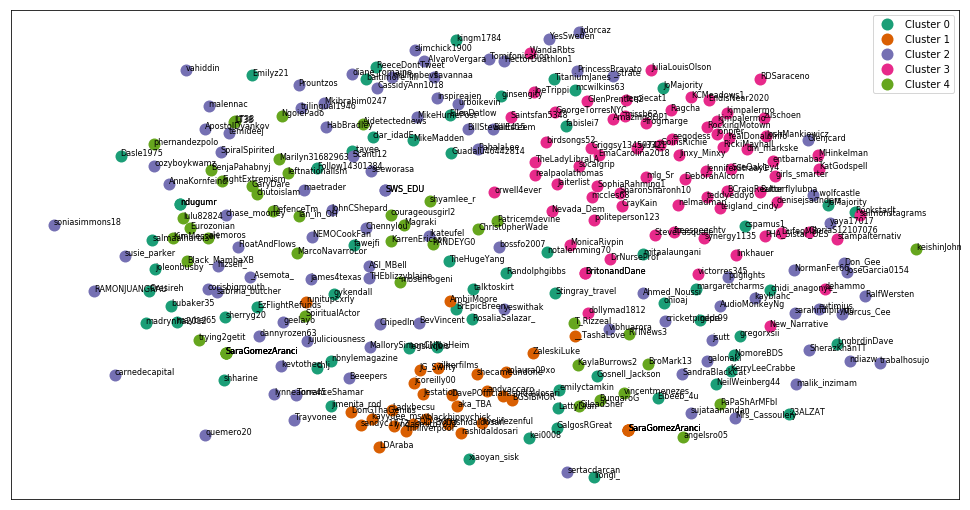

In [120]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

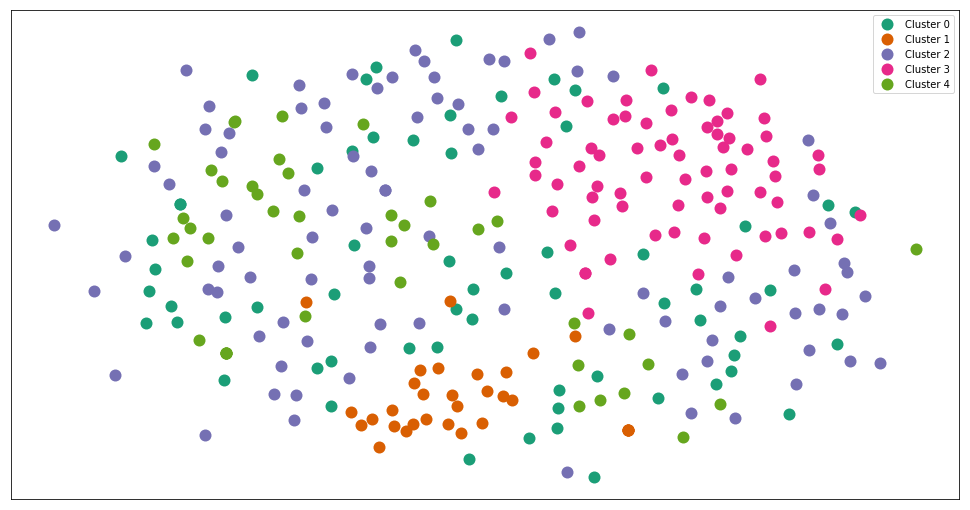

In [121]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [124]:
#adding cluster labels in the usersData 
usersData['cluster'] = clusters

In [125]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets,cluster
0,Follow14301384,1.18314,False,3828,[Exclusive: Footage obtained by Sky News track...,obtain sky news track final hour one sri bombe...,0
1,TitaniumJanes,1.02724,False,87414,[I don't think the economy is great. \n\nGroce...,dont think great higher higher minimum wage ta...,0
2,BillEsteem,1.0029,False,11173,[Guantanamo Bay commander fired over 'loss of ...,bay command fire loss renew sector project coa...,2
3,JoseGarcia0154,1.96629,False,5919,"[@NachoRgz @QuesaVerdades Es muy fácil hablar,...",son prejudicial tweet bien verbal junto best i...,2
4,clar_idadE,1.19273,False,105001,[Atrocidades contra los nicaragüenses podrían ...,contra important pan minimum wage would today ...,0


## 4. Perform Sentiment Analysis and Topic Modelling

In [160]:
# Import required packages
import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases

import os

Let's find bigrams and trigrams which appear at least 10 times in the corpus

In [150]:
docs = array(usersData['ptweets'].apply(lambda x: x.split()))

bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [154]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

Let's create a dictionary representation of the documents and remove rare and common tokens

In [155]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 511
Number of documents: 300
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1)]]


In [157]:
usersData['corpus'] = corpus
usersData['docs'] = docs
#create unique list of names
UniqueNames = usersData['cluster'].unique()

In [158]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [159]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = usersData[:][usersData.cluster == key]
    docscluster[key]=usersData['docs'][usersData.cluster == key]
    corpuscluster[key]=usersData['corpus'][usersData.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [162]:
os.environ['PATH'] += ":/usr/local/go/bin"

In [164]:
os.environ['MALLET_HOME'] = 'C:\\users\\\archd\\AppData\\Local\\Temp\\mallet-2.0.8'

mallet_path = 'C:\\users\\\archd\\AppData\\Local\\Temp\\mallet-2.0.8\\bin\\mallet'
ldamallet = LdaMallet(mallet_path, corpus = corpus, id2word = dictionary, iterations = 30)

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = "/mallet-2.0.8/bin/mallet" # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=26, id2word=dictionary)

CalledProcessError: Command 'C:\users\rchd\AppData\Local\Temp\mallet-2.0.8\bin\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\archd\AppData\Local\Temp\5f8c57_corpus.txt --output C:\Users\archd\AppData\Local\Temp\5f8c57_corpus.mallet' returned non-zero exit status 1.

Let's compute coherence score.

In [45]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3193428281160888


Function to loop computing coherence measures for tuning LDAMallet model

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Running and storing LDA models. Arbitrarily set minimum number of topic for each cluster=2, maximum number of topics=6

In [47]:
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i], corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=6, step=1)

In [48]:
# Print the coherence scores
import math
best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print(t)
    #print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

1
1
0
0
1


print coherence values for all tuned lda models in each cluster

In [49]:
coherence_values

{1: [0.3678713616263618,
  0.4272237313904827,
  0.39048825313559343,
  0.39056582346485624],
 2: [0.5408115879641322,
  0.519217599994347,
  0.5227223504826379,
  0.478231130550236],
 3: [0.6519933315733226,
  0.6275364745928904,
  0.6338824708583294,
  0.6419408003249354],
 4: [0.39688580312039073,
  0.47290820061248423,
  0.46204265492208074,
  0.46296691905221926],
 0: [0.5587818605209938,
  0.5950992064053237,
  0.5777535342419807,
  0.5391496430482267]}

In [50]:
optimal_model[i].print_topics(num_words=4)

[(0, '0.036*"analyst" + 0.033*"call" + 0.033*"beer" + 0.030*"respond"'),
 (1, '0.050*"play" + 0.035*"news" + 0.032*"catch" + 0.032*"growth"'),
 (2, '0.055*"classroom" + 0.046*"brilliant" + 0.046*"mission" + 0.035*"jail"')]

Visualize Tuning process. The optimal model would select as many number of topics which maximizes the coherence value.

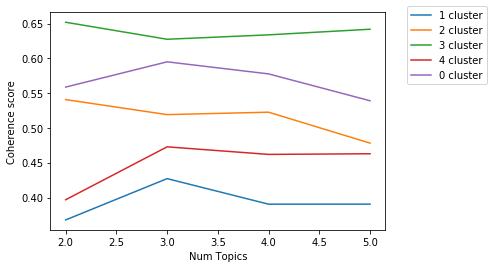

In [165]:
import matplotlib.pyplot as plt
limit=6; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)

In [52]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#### Sentiment Analysis using Textblob

In [53]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

Create Dataframe dictionary for polarity and subjectivity values vis-a-vis each cluster


In [54]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'])).sentiment.polarity
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'])).sentiment.subjectivity


Print polarity clusters for each cluster

In [55]:
polaritycluster

{1: 0.12364994378208993,
 2: 0.11674395152631759,
 3: 0.061727113953910374,
 4: 0.08522135740490171,
 0: 0.05722877757239255}

Print subjectivity score for each cluster

In [56]:
subjectivitycluster

{1: 0.470103595402198,
 2: 0.46632084405893887,
 3: 0.45692446276278614,
 4: 0.44770781609389165,
 0: 0.4407437450256602}

Visualize the topics

In [89]:
 #Visualize the topics
pyLDAvis.enable_notebook()
lda_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[1])
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpuscluster[1], dictionarycluster[1])
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000837  0.000068       1        1  33.713448
1      0.000357 -0.000727       2        1  33.158856
2      0.000480  0.000659       3        1  33.127696, topic_info=     Category      Freq           Term     Total  loglift  logprob
163   Default  1.000000           fuel  1.000000  30.0000  30.0000
1249  Default  1.000000           push  1.000000  29.0000  29.0000
35    Default  1.000000           rais  1.000000  28.0000  28.0000
1201  Default  1.000000           dean  1.000000  27.0000  27.0000
1150  Default  1.000000         length  1.000000  26.0000  26.0000
268   Default  1.000000           hell  1.000000  25.0000  25.0000
1026  Default  1.000000        highway  1.000000  24.0000  24.0000
1137  Default  1.000000          guess  1.000000  23.0000  23.0000
1061  Default  1.000000     profession  1.000000  22.0000  22.0000
686   Default  1.000000         differ  1.000000  21.0000  21.0000
525   Default  1.000000         island  1.000000  20.0000  20.0000
1260  Default  1.000000          freak  1.000000  19.0000  19.0000
31    Default  1.000000         planet  1.000000  18.0000  18.0000
560   Default  1.000000          organ  1.000000  17.0000  17.0000
52    Default  1.000000           work  1.000000  16.0000  16.0000
430   Default  1.000000          plane  1.000000  15.0000  15.0000
156   Default  1.000000       contract  1.000000  14.0000  14.0000
586   Default  1.000000         govern  1.000000  13.0000  13.0000
449   Default  1.000000         fourth  1.000000  12.0000  12.0000
650   Default  1.000000          stamp  1.000000  11.0000  11.0000
28    Default  1.000000           need  1.000000  10.0000  10.0000
491   Default  1.000000         search  1.000000   9.0000   9.0000
315   Default  1.000000        alright  1.000000   8.0000   8.0000
412   Default  1.000000         beyond  1.000000   7.0000   7.0000
538   Default  1.000000         winner  1.000000   6.0000   6.0000
644   Default  1.000000      resurrect  1.000000   5.0000   5.0000
27    Default  1.000000         nation  1.000000   4.0000   4.0000
551   Default  1.000000          didnt  1.000000   3.0000   3.0000
696   Default  1.000000          prime  1.000000   2.0000   2.0000
659   Default  1.000000        condemn  1.000000   1.0000   1.0000
...       ...       ...            ...       ...      ...      ...
1020   Topic3  0.465068        checker  1.243066   0.1216  -7.0068
450    Topic3  0.457557           open  1.224275   0.1206  -7.0231
86     Topic3  0.445492         growth  1.192153   0.1205  -7.0498
288    Topic3  0.464193         strang  1.242836   0.1200  -7.0087
685    Topic3  0.441014         detail  1.182647   0.1184  -7.0599
962    Topic3  0.462747           blue  1.241440   0.1180  -7.0118
130    Topic3  0.477802  state_plastic  1.282341   0.1176  -6.9798
166    Topic3  0.470150         happen  1.261930   0.1175  -6.9959
629    Topic3  0.456496      extremist  1.226563   0.1164  -7.0254
637    Topic3  0.466222           name  1.254918   0.1146  -7.0043
419    Topic3  0.473102         grader  1.273896   0.1143  -6.9897
786    Topic3  0.521094          minim  1.410661   0.1089  -6.8930
994    Topic3  0.478161          queen  1.289598   0.1127  -6.9790
1068   Topic3  0.488295          bravo  1.330338   0.1025  -6.9580
1232   Topic3  0.495341         recent  1.362410   0.0930  -6.9437
747    Topic3  0.477125         result  1.297179   0.1046  -6.9812
748    Topic3  0.482684         survey  1.326466   0.0939  -6.9696
304    Topic3  0.478712           lead  1.313898   0.0951  -6.9779
348    Topic3  0.481429        descend  1.333752   0.0858  -6.9722
264    Topic3  0.489098         doctor  1.373662   0.0721  -6.9564
380    Topic3  0.494571           home  1.409897   0.0572  -6.9453
1179   Topic3  0.479691        boycott  1.331459   0.0839  -6.9758
624    Topic3  0.479864           damn  1.332583   0.0834  -6.9755
11

In [90]:
pyLDAvis.save_html(vis2, 'lda1.html') #save the visualization

## 5. Collect and Analyze News articles

In [60]:
# Using newspaper3k package
import newspaper
from newspaper import Article

# for similarity measure
from sklearn.metrics.pairwise import cosine_similarity

We will suggest an article from following three News Service Providers
- CNN
- Washington Post
- New York Times

In [91]:
cnn_paper = newspaper.build('https://www.cnn.com/')cnn_paper = newspaper.build('http://www.cnn.com/', language='en') #CNN paper
WP_paper = newspaper.build('https://www.washingtonpost.com',language='en') # WP paper 
NYT_paper = newspaper.build('https://www.nytimes.com',language='en') # NYT paper

C:\Users\Lenovo\Anaconda3\envs\nlt\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Lenovo\Anaconda3\envs\nlt\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)


#### Extracting recent articles 

In [158]:
import pandas as pd
df_text = pd.DataFrame(columns=['Link','text'])
for article in cnn_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in WP_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in NYT_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass 

C:\Users\Lenovo\Anaconda3\envs\nlt\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)


In [ ]:
df_text

Let's perform cleaning on news articles and for that we can use previous processTweets function which is designed to clean tweets

In [ ]:
df_text['text'] = df_text['text'].apply(lambda x : processTweets(x))

Let's find out bigrams and trigrams

In [ ]:
docs = array(df_text['text'].apply(lambda x : x.split())
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Let's calculate Sentiment score for news articles

In [ ]:
pol=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.polarity for i in range(df_text.shape[0])]
sub=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.subjectivity for i in range(df_text.shape[0])]
df_text['pol']=pol
df_text['sub']=sub

In [ ]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Let's assign topic modelling scores to every news articles for each of the optimal topic model developed

In [ ]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[i])
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    
    # Centre the percent contribution by subtracting the mean. This standardises topic score
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

Let's compute sentiment score using cosine similarity between cluster scores and scores obtained from news articles


In [ ]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([polaritycluster[i]]).reshape(-1, 1))
    subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Polarity']=sentiment[i]
    df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff']+w2/2*(df_topic_sents_keywords[i]['Polarity']+df_topic_sents_keywords[i]['Subjectivity'])

## 6. Get user’s Twitter handle & Recommend news articles

In [ ]:
# Recommendation dataframe
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,7])
        
    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])

In [ ]:
recommend['metric']=metric_value
recommend['url']=df_text['Link']

#np.array([recommend,metric_value])
recommend #0 is cluster group

In [ ]:
recommend.sort_values(by=['metric', 0], ascending ='False')

In [ ]:
import seaborn as sns
plt.bar(recommend[0].value_counts().index,recommend[0].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [ ]:
df_topic_sents_keywords